# *n2i*: analysis

### TOC:
* [Demo](#Demo)
* [Analysis](#Analysis)
* [Grid search](#Grid search)

## Demo

n2i can be used both in command line and Jupyter notebook. The following code runs n2i with the default parameters.

NB: REMEBER TO DEFINE IF THE GRAPH IS DIRECTED AND/OR WEIGHTED

In [1]:
import pathlib
import numpy as np
import pandas as pd
import networkx as nx
from scipy.spatial import distance
from n2i.__main__ import n2i_main, n2i_nx_graph
from n2i.node2vec import read_graph

In [2]:
graph_path = '../data/graph/lesmiserables/lesmiserables_edgelist.txt'

graph = read_graph(weighted=False, 
               graph=graph_path,
               directed=False)

In [3]:
emb = n2i_nx_graph(nx_graph=graph, topics=3)

## Homophily metrics

We use three homophily metrics. All three are based on a sample of edges $S^+ \subseteq E$ and a sample of non-edges $S^- \subseteq (V \times V \setminus E)$. On these, we need to employ a measure of similarity between nodes $\delta: V \times V \rightarrow [0, 1]$. This will be one minus the cosine distance between their interest vectors.

### Ratio

$$ \frac{\sum_{i, j \in S^+} \delta(i, j)}{\sum_{i, j \in S^-} \delta(i, j)} $$
  Which is what we've been using until now. This measure of homophily is **not bounded** as it lives in $[0, \infty]$. This means we have 0 for the ideal case of no homophily (there is 0 similarity in links and a positive similarity in non links) and $\infty$ for the ideal case of homophily (there is similarity 1 in links and 0 in non links). This measure is "scale free": if all the links have similarity 1 and the non links have similarity 0.1 is **the same** as if they have similarity 0.1 and 0.01, respectively.
  
### Subtraction

$$ \frac{1}{|S^+|}{\sum_{i, j \in S^+} \delta(i, j)} - \frac{1}{|S^-|} {\sum_{i, j \in S^-} \delta(i, j)} $$. This measure lives in $[-1, 1]$ (corresponding to the two ideal case said before). It is not scale free: it needs for the difference to be as close as possible to 1.

### Probabilistic

If we assume that $P \bigg( (i, j) \in E \bigg) = \delta(i, j)$, then we can define homophily as the log likelihood of the graph we observe under this assumption. That would be: $$
\log \Bigg( \prod_{(i, j) \in S^+} \delta(i, j) \cdot \prod_{(i, j) \in S^-} (1 - \delta(i, j) ) \Bigg) = $$  $$
\sum_{(i, j) \in S^+} \log \delta(i, j) + \sum_{(i, j) \in S^-} \log \big( 1 - \delta(i, j) \big)
$$ Even if in practice we will need to use $\log(x + \epsilon)$ for a small $\epsilon$ to avoid errors in case a link with $0$ homophily actually exists or viceversa (a $(i,j)$ with $1$ does not). This measure lives in $[-\infty, 0]$; the perfect lack of homophily can go arbitrarily down, the ideal case will be always rated as $0$. It is not scale free: it needs for the difference to be as close as possible to 1. Also, this measure will give different results for network of different sizes: a graph with more nodes will have lower likelihood.



In [35]:
EPSILON = 1E-5
METRIC_NAMES = ['ratio', 'sub', 'like']
def homophily_metrics(similarity_edges, similarity_nonedges):
    return {
        'ratio': np.mean(similarity_edges) / np.mean(similarity_nonedges),
        'sub': np.mean(similarity_edges) - np.mean(similarity_nonedges),
        'like': np.sum(np.log(similarity_edges + EPSILON)) + np.sum(np.log(1 - similarity_nonedges + EPSILON)) ,
    }

## Analysis

In [9]:
# similarity between connected nodes
def sim_in(G):
    sims = []
    for i in G.nodes:
        for j in list(G.neighbors(i)):
            sims.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims)

def select_notedge(G):
    v1 = np.random.choice(G.nodes())
    v2 = np.random.choice(G.nodes())

    while (v1,v2) in G.edges or v1==v2:
        v1 = np.random.choice(G.nodes())
        v2 = np.random.choice(G.nodes())
    return v1, v2
#     n = nx.number_of_nodes(G)
#     while True:
#         a, b = np.random.randint(0, n, size=2)
#         if (a, b) not in G.edges:
#             return a, b

# similarity between disconnected nodes
def sim_out(G, samples):
    sims_out = []
    for c in range(samples):
        i, j = select_notedge(G)
        sims_out.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims_out)

In [17]:
metric = list(homophily_metrics(si, so).items())[0]

In [34]:
# graph_path = '../WoMG/data/graph/lesmiserables/lesmiserables_edgelist.txt'

# graph = read_graph(weighted=False, 
#                graph=graph_path,
#                directed=False)

# emb = n2i_nx_graph(nx_graph=graph, topics=3)
for i in graph.nodes:
    graph.node[i]['interests'] = emb[i]

si = sim_in(graph)
so = sim_out(graph, 5000)
print ("In similarity: {:.4f} \nOut similarity: {:.4f} \n".format(si, so, 2))
print('\n'.join('Homophily rate ({}): {:.4f}'.format(*metric) for metric in homophily_metrics(si, so).items()))

In similarity: 0.9680 
Out similarity: 0.7123 

Homophily rate (ratio): 1.3589
Homophily rate (sub): 0.2557
Homophily rate (like): -1.2784


## Grid search

In [46]:
graph = '../data/graph/lesmiserables/lesmiserables_edgelist.txt'
G = read_graph(weighted=False, 
               graph=graph,
               directed=False)
# p_val = [0.25, 0.5, 0.75, 1.25, 1.5, 1.75, 2]
# q_val = [0.25, 0.5, 0.75, 1.25, 1.5, 1.75, 2]

p_val = [0.25, 2]
q_val = [0.25, 2]

topics=[15]
dimensions=[128]
walk_length=[80]
num_walks=[10]
window_size=[10]
iiter=[1]

In [47]:
stat = []

In [49]:
args_list = []

# nr_experiments = 20
nr_experiments = 1

for t in topics:
    for d in dimensions:
        for wk in walk_length:
            for n in num_walks:
                for wi in window_size:
                    for ii in iiter:
                        for p in p_val:
                            for q in q_val:
                                for seed in range(nr_experiments):
                                    args = [t, d, wk, n, wi, ii, p, q, seed]
                                    args_list.append(args)

In [50]:
def run_experiment(*args):
    t, d, wk, n, wi, ii, p, q, seed = args
    G_emb = n2i_nx_graph(nx_graph=G, topics=t, 
             dimensions=d, walk_length=wk,
             num_walks=n, window_size=wi,
             iiter=ii, p=p, q=q,
             seed=seed+int(1000*(q+p)))
    for i in G.nodes:
        G.node[i]['interests'] = G_emb[i]
    si = sim_in(G)
    so = sim_out(G, 5000)
    metrics = homophily_metrics(si, so)
    return args + tuple(metrics[metric_name] for metric_name in METRIC_NAMES)

In [51]:
run_experiment(*args_list[0])

(15,
 128,
 80,
 10,
 10,
 1,
 0.25,
 0.25,
 0,
 1.4663480083103053,
 0.294485879473552,
 -1.0751277795931196)

In [52]:
result = list(map(lambda x: run_experiment(*x), args_list))

In [53]:
df = pd.DataFrame(result, columns=['t', 'd', 'wk', 'n', 'wi', 'ii', 'p', 'q', 'seed',
                                   *['hom_%s' % s for s in METRIC_NAMES]])
df.head()

,t,d,wk,n,wi,ii,p,q,seed,hom_ratio,hom_sub,hom_like
0,15,128,80,10,10,1,0.25,0.25,0,1.567581,0.332935,-0.967173
1,15,128,80,10,10,1,0.25,2.00,0,1.622753,0.342527,-0.912196
2,15,128,80,10,10,1,2.00,0.25,0,1.378304,0.236179,-1.129209
3,15,128,80,10,10,1,2.00,2.00,0,1.396736,0.264654,-1.170518


In [54]:
df2 = df.groupby(['p', 'q'])['hom_ratio'].mean().unstack()

In [55]:
%pylab inline

import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0.5,1,'Homophily (mean of 20 realizations)')

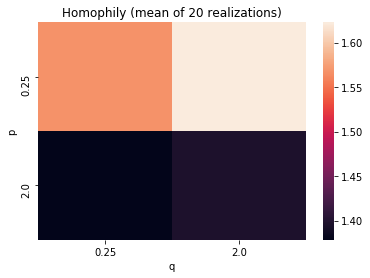

In [56]:
sns.heatmap(df2)
plt.title('Homophily (mean of 20 realizations)')

In [58]:
df.hom_ratio.min(), df.hom_ratio.max()

(1.37830373551764, 1.6227528882923294)